# Preprocessing data for 3D ocean emulation

## Outstanding issues for generalization
- Ocean surface fields on different grid than the 3d outputs (CM4 specific) [Link]("ocean_surf_on_different_grid")
- [>] Are the CMIP velocities really already on the tracer grid? [Issue](https://github.com/m2lines/ocean_emulators/issues/19#issue-2362588496)
- TODO: Figure out the masking properly (https://xesmf.readthedocs.io/en/stable/user_api.html see `skipna` etc) -> See the antarctic 0 fields
- Add area and dz to the output dataset (this is tricky since it is affected by masking/spatial regridding)
- TODO: replace x/y with nominal lon/lat (works nicely with the cut off in the north)
- Preserve units/long name for all variables

In [1]:
## relying on all the dangling branches 🙈
# !pip install git+https://github.com/jbusecke/xgcm.git@conservative_transform_w_nans 

In [2]:
# !pip install git+https://github.com/ocean-transport/scale-aware-air-sea@kwargs-for-open-close

In [3]:
# !pip install -e /home/jovyan/PROJECTS/ocean_emulators/

In [4]:
from scale_aware_air_sea.utils import to_zarr_split

In [5]:
from ocean_emulators.preprocessing import vertical_regrid, infer_vertical_cell_extent, spatially_regrid
import intake
import xarray as xr
import numpy as np
from xmip.preprocessing import combined_preprocessing
to_ddict_kwargs = dict(aggregate=False, preprocess=combined_preprocessing)

In [6]:
import os
os.environ['JUPYTER_IMAGE_SPEC']

'pangeo/pangeo-notebook:2024.06.02'

In [7]:
from distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/proxy/8787/status,
Dashboard: /user/jbusecke/proxy/8787/status,Workers: 8
Total threads: 64,Total memory: 503.88 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34909,Workers: 8
Dashboard: /user/jbusecke/proxy/8787/status,Total threads: 64
Started: Just now,Total memory: 503.88 GiB
Comm: tcp://127.0.0.1:44835,Total threads: 8
Dashboard: /user/jbusecke/proxy/41791/status,Memory: 62.99 GiB
Nanny: tcp://127.0.0.1:36833,


In [7]:
#From https://github.com/m2lines/ocean_emulators/issues/17
target_vertical_levels = np.array([   0,    5,   15,   30,   50,   80,  130,  200,  300,  450,  650,
        900, 1200, 1600, 2100, 2700, 3500, 4500, 5500, 6500])

In [9]:
# uncomment/comment lines to swap catalogs
url = "https://storage.googleapis.com/cmip6/cmip6-pgf-ingestion-test/catalog/catalog.json" # Only stores that pass current tests
col = intake.open_esm_datastore(url)

In [10]:
# Quick workaround for https://github.com/leap-stc/cmip6-leap-feedstock/issues/146
url = "https://storage.googleapis.com/cmip6/cmip6-pgf-ingestion-test/catalog/catalog_noqc.json" # Only stores that fail current tests
col_no_qc = intake.open_esm_datastore(url)

In [11]:
cat_atmos = col.search(source_id='GFDL-CM4', experiment_id='piControl', variable_id=['hfls', 'hfss'], table_id='Amon')
display(cat_atmos.df)
ddict_atmos = cat_atmos.to_dataset_dict(**to_ddict_kwargs)
# # rechunk in time only
# ddict_atmos = {k:ds.chunk({'time':1, 'x':-1, 'y':-1}) for k,ds in ddict_atmos.items()}

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,sub_experiment_id,variant_label,version,zstore
0,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Amon,hfls,gr1,none,r1i1p1f1,v20180701,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...
1,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Amon,hfss,gr1,none,r1i1p1f1,v20180701,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.sub_experiment_id.variant_label.version.zstore'


<a id="ocean_surf_on_different_grid"></a>

In [12]:
cat_ocean = col.search(source_id='GFDL-CM4', experiment_id='piControl', table_id='Omon', variable_id=['so', 'thetao', 'uo', 'vo'], grid_label='gn') #TODO: u and v are only on gn grid
cat_ocean_surf = col.search(source_id='GFDL-CM4', experiment_id='piControl', table_id='Omon', variable_id=['zos'], grid_label='gr')
display(cat_ocean.df)
display(cat_ocean_surf.df)
ddict_ocean = cat_ocean.to_dataset_dict(**to_ddict_kwargs)
# ddict_ocean = {k:ds.chunk({'time':1, 'x':-1, 'y':-1}) for k,ds in ddict_ocean.items()}
ddict_ocean_surf = cat_ocean_surf.to_dataset_dict(**to_ddict_kwargs)
# ddict_ocean_surf = {k:ds.chunk({'time':1, 'x':-1, 'y':-1}) for k,ds in ddict_ocean_surf.items()}

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,sub_experiment_id,variant_label,version,zstore
0,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Omon,uo,gn,none,r1i1p1f1,v20180701,gs://cmip6/cmip6-pgf-ingestion-test/zarr_store...
1,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Omon,vo,gn,none,r1i1p1f1,v20180701,gs://cmip6/cmip6-pgf-ingestion-test/zarr_store...
2,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Omon,so,gn,none,r1i1p1f1,v20180701,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...
3,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Omon,thetao,gn,none,r1i1p1f1,v20180701,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,sub_experiment_id,variant_label,version,zstore
0,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Omon,zos,gr,none,r1i1p1f1,v20180701,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.sub_experiment_id.variant_label.version.zstore'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.sub_experiment_id.variant_label.version.zstore'


## Rechunk and save out/reload again to harmonize chunking structure and avoid rechunking on the fly


In [13]:
from scale_aware_air_sea.utils import maybe_save_and_reload
import gcsfs

prefix = "gs://leap-scratch/jbusecke/ocean-emulators/temp"

# fs = gcsfs.GCSFileSystem()
# fs.rm(prefix, recursive=True)

def rechunk(ds:xr.Dataset) -> xr.Dataset:
    target_chunks = {"time": 1, "x": -1, "y": -1, "lev": -1, "bnds": 2, 'vertex':4}
    valid_target_chunks = {k: c for k, c in target_chunks.items() if k in ds.dims}
    ds = ds.chunk(valid_target_chunks)
    # this is dumb, but lets get this over with
    ds.encoding = {}
    for v in ds.variables:
        ds[v].encoding={}
    return ds
    
ddict_ocean_surf = {
    k: maybe_save_and_reload(
        rechunk(ds),
        f"{prefix}/ddict_ocean_surf_{k}.zarr",
        split=True, 
        to_zarr_split_kwargs=dict(split_interval=1000)
    )
    for k, ds in ddict_ocean_surf.items()
}
ddict_ocean = {
    k: maybe_save_and_reload(
        rechunk(ds),
        f"{prefix}/ddict_ocean_{k}.zarr",
        split=True, 
        to_zarr_split_kwargs=dict(split_interval=500)
    )
    for k, ds in ddict_ocean.items()
}
ddict_atmos = {
    k: maybe_save_and_reload(
        rechunk(ds),
        f"{prefix}/ddict_atmos_{k}.zarr",
        split=True, 
        to_zarr_split_kwargs=dict(split_interval=2000)
    )
    for k, ds in ddict_atmos.items()
}

Reload dataset from gs://leap-scratch/jbusecke/ocean-emulators/temp/ddict_ocean_surf_CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Omon.zos.gr.none.r1i1p1f1.v20180701.gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piControl/r1i1p1f1/Omon/zos/gr/v20180701/.zarr
Reload dataset from gs://leap-scratch/jbusecke/ocean-emulators/temp/ddict_ocean_CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Omon.so.gn.none.r1i1p1f1.v20180701.gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piControl/r1i1p1f1/Omon/so/gn/v20180701/.zarr
Reload dataset from gs://leap-scratch/jbusecke/ocean-emulators/temp/ddict_ocean_CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Omon.thetao.gn.none.r1i1p1f1.v20180701.gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piControl/r1i1p1f1/Omon/thetao/gn/v20180701/.zarr
Reload dataset from gs://leap-scratch/jbusecke/ocean-emulators/temp/ddict_ocean_CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Omon.uo.gn.none.r1i1p1f1.v20180701.gs://cmip6/cmip6-pgf-ingestion-test/zarr_stores/9555660527_1/CMIP6.CMIP.NOAA-GFDL.GFDL-CM4.p

**TODO**: I don't understand why the bounds are all the sudden coordinates? But its easy enough to fix for now

In [14]:
# Temp fix
def fix_coords(ds:xr.Dataset)-> xr.Dataset:
    return ds.set_coords([va for va in ds.data_vars if va != ds.attrs['variable_id']])
ddict_ocean = {k:fix_coords(ds) for k,ds in ddict_ocean.items()}
ddict_atmos = {k:fix_coords(ds) for k,ds in ddict_atmos.items()}
ddict_ocean_surf = {k:fix_coords(ds) for k,ds in ddict_ocean_surf.items()}

In [15]:
cat_grid_fixed = col_no_qc.search(source_id='GFDL-CM4', experiment_id='piControl', table_id=['Ofx', 'fx'], variable_id=['deptho', 'thkcello', 'areacello'], grid_label=['gr', 'gn'])
display(cat_grid_fixed.df)
ddict_grid_0 = cat_grid_fixed.to_dataset_dict(**to_ddict_kwargs)
import warnings
warnings.warn("this should not be necessary once I rerun the rechunking again")
ddict_grid_0 = {k:ds.squeeze() for k,ds in ddict_grid_0.items()}

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,sub_experiment_id,variant_label,version,zstore
0,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Ofx,deptho,gn,none,r1i1p1f1,v20180701,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...
1,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Ofx,thkcello,gr,none,r1i1p1f1,v20180701,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...
2,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Ofx,areacello,gn,none,r1i1p1f1,v20180701,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...
3,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Ofx,deptho,gr,none,r1i1p1f1,v20180701,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...
4,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Ofx,thkcello,gn,none,r1i1p1f1,v20180701,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...
5,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Ofx,areacello,gr,none,r1i1p1f1,v20180701,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.sub_experiment_id.variant_label.version.zstore'


/tmp/ipykernel_14006/3509867939.py:5: UserWarning: this should not be necessary once I rerun the rechunking again
  warnings.warn("this should not be necessary once I rerun the rechunking again")


## Interpolate velocities onto tracer grid before any of the vertical regridding

TODO: check the implications for the wetmask here
FIXME: This needs more upstream work, since all the values for CM4 are on the center coordinate, pass through here for now

What I generally need here is a three step process

- Group datasets that should be combined with `combine_datasets`
- Find ref dataset, and detect lon/lat shifts for all other datasets
- parse datasets something like this: combine(ds_ref, [(ds_a, {'X':'left', 'Y':'center'}), (ds_b, {'X':'center', 'Y':'left'})])

Then i want to get a single datasets that has x, x_left, y, y_left coordinates and the data arrays from each one of them located appropriately within the output dataset
Also make sure that dataset can be immediately be metadata parsed for xgcm


In [16]:
# # This is a rewrite from xmip and needs to be upstreamed
# # from xmip.grids import combine_staggered_grid does not work anymore with modern xgcm version

# # What is new: 
# # - no more attempting to recreate metrics, if they are on the datasets, then parse them, otherwise dont do any calculations
# # - no way to overwrite the inferred shifts! The only way to manually change the position is to manipulate the metadata!

# # Questions: What about the depth? Should I parse the outer coordinates here?

# t = ddict_ocean['CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Omon.thetao.gn.none.r1i1p1f1.v20180701.gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piControl/r1i1p1f1/Omon/thetao/gn/v20180701/']
# u = ddict_ocean['CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Omon.uo.gn.none.r1i1p1f1.v20180701.gs://cmip6/cmip6-pgf-ingestion-test/zarr_stores/9555660527_1/CMIP6.CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Omon.uo.gn.v20180701.zarr']
# v = ddict_ocean['CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Omon.vo.gn.none.r1i1p1f1.v20180701.gs://cmip6/cmip6-pgf-ingestion-test/zarr_stores/9555660527_1/CMIP6.CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Omon.vo.gn.v20180701.zarr']


# ds_base = t
# ds_other = [u,v]
# # just for testing (needs to be done with a lon/lat comparison in the full workflow)
# u_modified = u.copy()
# u_modified.x.attrs['c_grid_axis_shift'] = 1

# v_modified = v.copy()
# v_modified.y.attrs['c_grid_axis_shift'] = 1
# ds_other = [u_modified, v_modified]

# from xgcm.metadata_parsers import parse_metadata
# from typing import Dict, Tuple, Union, List

# def combine_staggered_grid(
#     ds_base, other_ds=None, 
#     default_shift:Union[Dict[str, Tuple[str, str]], Tuple[str, str]]=('center', 'left'),
#     exclude_axes:List[str]=['T'],
# ):
#     """
    
#     """
#     # figure out the shifts from base, if no other position than center is detected use some default?
#     # Only datasets with parseable metadata are accepted (any manual modification needs to be made before passing the inputs.
#     base_w_metadata = parse_metadata(ds_base)
#     other_w_metadata = [parse_metadata(ds) for ds in other_ds]
#     #TODO: I am not sure what this would do if it failed. Need to check with a different source_id
#     # TODO: Raise a useful error message that displays the error and the iid of the dataset

#     # collect unique axes:
#     all_metadata = [m for ds,m in [base_w_metadata]+other_w_metadata]
#     #TODO test that there will always be one value per axis?
    
#     axes_w_positions = {}
#     for md in all_metadata:
#         for axis, p_dict in md['coords'].items():
#             print(axis, p_dict)
#             for dim, pos in p_dict.items():
#                 if not axis in exclude_axes:
#                     if axis not in axes_w_positions.keys():
#                         axes_w_positions[axis] = []
#                     axes_w_positions[axis].extend(positions.keys())
    
#     # make sure positions are unique
#     axes_w_positions = {axis:list(set(positions)) for axis,positions in axes_w_positions.items()}

#     # Maybe expand default shifts to each axis
#     if not isinstance(default_shift, dict):
#         default_shift = {ax:default_shift for ax in axes_w_positions.keys()}

#     for ax, pos in axes_w_positions.items():
#         if len(pos) > 2:
#             raise ValueError(f"Cannot create a staggered xgcm grid with more than 2 positions per axis. Got {pos} for axis {ax}")
#         elif len(pos) == 1:
#             fill = default_shift[ax]
#             fill = [f for f in fill if f not in pos][0]
#             print(f"Only found a single axis position for axis {ax}. Filling in default shift value {fill}")
#             axes_w_positions[ax].append(fill)
    
#     # create the new dimensions according to the shift (retain the naming of ref dataset, and add suffix for all others)
    
#     ds_base, metadata_base = base_w_metadata
#     for ax, pos in axes_w_positions.items():
#         # determine which position is on the ref dataset
#         ref_pos = metadata_base['coords'][ax].keys()[0]
#         # determine the name for the new dimension and add it to the dataset
#         # TODO: Should this have coordinate values?
#         new_pos = [pos for pos in axes_w_positions[ax] if pos != ref_pos][0]
#         print(new_pos)
#         new_dimension = 1
#         print(new_dimension)
#     #then loop over "other" datasets and rename+add them so they sit on the appropriate positions of the output 
#     return axes_w_positions, metadata_base

# combine_staggered_grid(ds_base, ds_other)

In [17]:
from xmip.postprocessing import match_metrics, merge_variables
ddict_combined_on_tracer = merge_variables(ddict_ocean) 

## Spatially regrid SSH for the depth inference (Shortcut, needs improvement)
This is needed for infering the cell depth, and certainly will influence accuracy (since this is much coarser res). 
For now I will use simple bilinear interpolation for this.

In [18]:
from xmip.postprocessing import combine_datasets, interpolate_grid_label
from typing import List

In [19]:
ddict_all_ocean = ddict_combined_on_tracer | ddict_ocean_surf
# ddict_all_ocean = {k:cmip_bounds_to_xesmf(ds) for k,ds in ddict_all_ocean.items()}
# ddict_all_ocean = interpolate_grid_label(ddict_all_ocean, target_grid_label='gn', method='conservative', )
# TODO: I need to factor out the _drop_duplicate_grid_label function (or make it optional)

In [20]:
# TODO: this should be an option for the xmip combine_grid_labels!
def _combine_grid_labels(ds_list:List[xr.Dataset]):
    # for now hardcode
    datasets = []
    matching_grid_datasets = []
    nonmatching_grid_datasets = []
    for ds in ds_list:
        if ds.attrs['grid_label'] == 'gn':
            matching_grid_datasets.append(ds)
        else:
            nonmatching_grid_datasets.append(ds)
        
    target_ds = matching_grid_datasets[0]
    datasets.append(target_ds)
    for ds in nonmatching_grid_datasets+matching_grid_datasets[1:]:
        # Not effective if there are multiple 'other' datasets (not worth improving here, fix upstream instead)
        ds_regridded = spatially_regrid(ds, target_ds)
        # strip the attr from these
        ds_regridded.attrs = {}
        # also stip coords
        ds_regridded = ds_regridded.reset_coords(drop=True)
        datasets.append(ds_regridded)
    return xr.merge(datasets)
        
ddict_all_ocean_final = combine_datasets(ddict_all_ocean, _combine_grid_labels, match_attrs=['source_id', 'experiment_id', 'table_id', 'variant_label'])
ddict_all_ocean_final

{'GFDL-CM4.piControl.Omon.r1i1p1f1': <xarray.Dataset> Size: 5TB
 Dimensions:            (y: 1080, x: 1440, bnds: 2, vertex: 4, lev: 35,
                         time: 6000)
 Coordinates: (12/14)
     lat                (y, x) float32 6MB -79.81 -79.81 -79.8 ... 64.22 64.11
     lat_bounds         (bnds, y, x) float32 12MB dask.array<chunksize=(2, 1080, 1440), meta=np.ndarray>
     lat_verticies      (y, x, vertex) float32 25MB -79.84 -79.78 ... 64.06 64.06
   * lev                (lev) float64 280B 2.5 10.0 20.0 ... 6e+03 6.5e+03
     lev_bounds         (lev, bnds) float64 560B dask.array<chunksize=(35, 2), meta=np.ndarray>
     lon                (y, x) float32 6MB 60.28 60.53 60.78 ... 60.0 60.0 60.0
     ...                 ...
     sub_experiment_id  <U4 16B 'none'
   * time               (time) object 48kB 0151-01-16 12:00:00 ... 0650-12-16 ...
     time_bounds        (time, bnds) object 96kB dask.array<chunksize=(1, 2), meta=np.ndarray>
     variant_label      <U8 32B 'r1i1p1f1'


## Combine and prep for vertical regridding

[This](https://github.com/jbusecke/xMIP/issues/355) came up when I tried to add 3d metrics to 2d fields

In [21]:
ddict_ocean_w_metrics = match_metrics(ddict_all_ocean_final, ddict_grid_0, ['deptho', 'thkcello', 'areacello'])

In [22]:
ddict_ocean_w_dz = {k:infer_vertical_cell_extent(ds) for k, ds in ddict_ocean_w_metrics.items()}

In [23]:
test = ddict_ocean_w_dz['GFDL-CM4.piControl.Omon.r1i1p1f1']

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 44.93 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


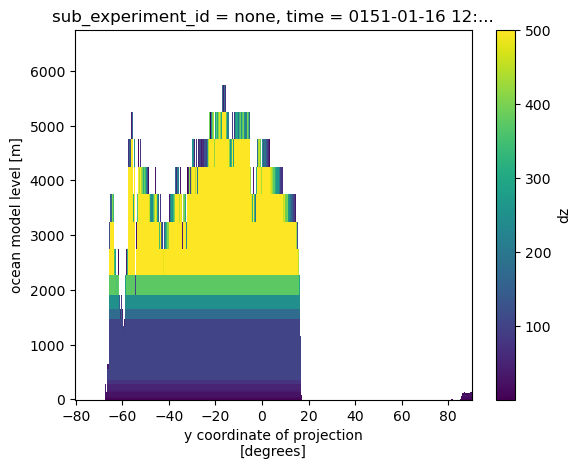

In [24]:
test.isel(time=0, x=90).dz.squeeze().plot()

Ah nice this actually seems to account for partial bottom cells!

In [25]:
ddict_vert_regridded = {k:vertical_regrid(ds, target_vertical_levels) for k, ds in ddict_ocean_w_dz.items()}

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/transform.py:255: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/transform.py:255: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/transform.py:255: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/transform.py:255: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


In [26]:
test = ddict_ocean_w_dz['GFDL-CM4.piControl.Omon.r1i1p1f1'].isel(time=slice(0,2))
test_regridded = ddict_vert_regridded['GFDL-CM4.piControl.Omon.r1i1p1f1'].isel(time=slice(0,2)).astype(np.float32)

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 44.94 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


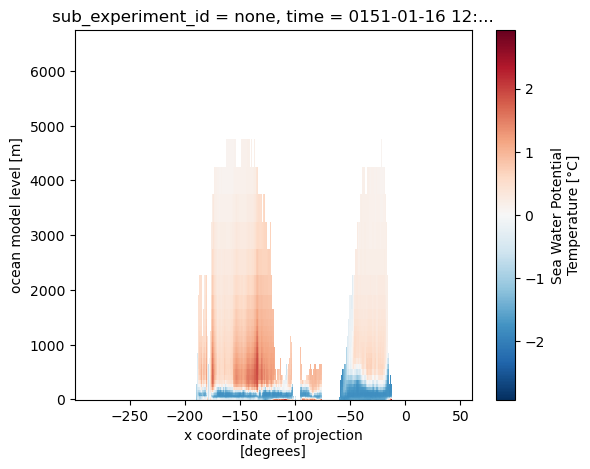

In [27]:
test.isel(time=0, y=90).thetao.squeeze().plot(x='x')

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 44.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


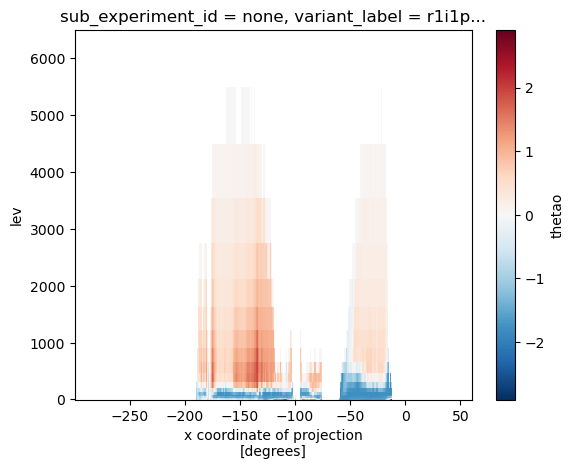

In [28]:
test_regridded.isel(time=0, y=90).thetao.squeeze().plot(x='x')

In [29]:
# int_test = (test.astype(np.float64)*test.dz).sum('lev').load()
# int_test_regridded = (test_regridded*test_regridded.dz).sum('lev').load()
# transpose_order=set(int_test.sizes.keys())
# int_test_regridded = int_test_regridded.transpose(*transpose_order)
# int_test = int_test.transpose(*transpose_order)
# still failing, but can prob get it to go with less tight tolerances...
# xr.testing.assert_allclose(int_test, int_test_regridded, rtol=1e-4, atol=1e-4) # depends on dtype of the output TODO: for more cmip models ill have to deal with this! I probably just have to cast things a bit smarter. Visually these have very small differences.

In [30]:
# int_test.thetao.isel(time=0).plot(x='x')

In [31]:
# int_test_regridded.thetao.isel(time=0).plot(x='x')

In [32]:
# (int_test-int_test_regridded).thetao.isel(time=0).plot(robust=True, x='x')

## Regrid and combine atmos and ocean

In [33]:
import xesmf as xe
from xmip.postprocessing import merge_variables

In [34]:
ddict_merged_atmos = merge_variables(ddict_atmos)

In [35]:
def regrid_and_merge_regular_grid(ds_list:List[xr.Dataset]) -> xr.Dataset:
    target_ds = xe.util.grid_global(1,1, lon1=360)
    datasets = []
    for ds in ds_list:
        ds_regridded = spatially_regrid(ds, target_ds)
        ds_regridded.attrs = ds.attrs
        datasets.append(ds_regridded)
    return xr.merge(datasets,combine_attrs='drop_conflicts')
ddict_rechunking = ddict_all_ocean_final|ddict_merged_atmos
# #not sure this is the best spot to do this (i guess I should do this earlier?
# ddict_rechunking = {k:ds.chunk({'x':-1, 'y':-1}) for k,ds in ddict_rechunking.items()}
ddict_final = combine_datasets(
    ddict_rechunking,
    regrid_and_merge_regular_grid,
    match_attrs=['source_id', 'experiment_id','variant_label'],
)

## Uniform masking (Shortcut, needs revisiting)

In [36]:
ds_test = ddict_final['GFDL-CM4.piControl.r1i1p1f1'].squeeze()
vars_3d = [v for v in ds_test.data_vars if 'lev' in ds_test[v].dims]
vars_2d = [v for v in ds_test.data_vars if not 'lev' in ds_test[v].dims]
masks_3d = [np.isnan(ds_test[var].isel(time=0)) for var in vars_3d]
masks_2d = [np.isnan(ds_test[var].isel(time=0)) for var in vars_2d] + [np.isnan(ds_test[var].isel(time=0, lev=0)) for var in vars_3d]
combined_mask_3d = sum(masks_3d).load()
combined_mask_2d = sum(masks_2d).load()

ds_masked = xr.Dataset(attrs=ds_test.attrs)
for v in ds_test.data_vars:
    if v in vars_2d:
        ds_masked[v] = ds_test[v].where(combined_mask_2d==0)
    else:
        ds_masked[v] = ds_test[v].where(combined_mask_3d==0)
ds_masked

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 45.08 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 96.49 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


<xarray.Dataset> Size: 222GB
Dimensions:            (lev: 35, time: 6000, y: 180, x: 360)
Coordinates:
  * lev                (lev) float64 280B 2.5 10.0 20.0 ... 6e+03 6.5e+03
    sub_experiment_id  <U4 16B 'none'
  * time               (time) object 48kB 0151-01-16 12:00:00 ... 0650-12-16 ...
    variant_label      <U8 32B 'r1i1p1f1'
    lon                (y, x) float64 518kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
    lat                (y, x) float64 518kB -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
Dimensions without coordinates: y, x
Data variables:
    so                 (time, lev, y, x) float32 54GB dask.array<chunksize=(1, 35, 180, 360), meta=np.ndarray>
    thetao             (time, lev, y, x) float32 54GB dask.array<chunksize=(1, 35, 180, 360), meta=np.ndarray>
    uo                 (time, lev, y, x) float32 54GB dask.array<chunksize=(1, 35, 180, 360), meta=np.ndarray>
    vo                 (time, lev, y, x) float32 54GB dask.array<chunksize=(1, 35, 180, 360), meta=np.ndarray>
    zos                (time, y, x) float32 2GB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    hfss               (time, y, x) float32 2GB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    hfls               (time, y, x) float32 2GB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes: (12/48)
    Conventions:                         CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                         CMIP
    branch_method:                       standard
    branch_time_in_child:                0.0
    branch_time_in_parent:               54750.0
    comment:                             <null ref>
    ...                                  ...
    variant_label:                       r1i1p1f1
    version_id:                          v20180701
    pangeo_forge_build_git_hash:         https://github.com/leap-stc/cmip6-le...
    pangeo_forge_gh_actions_url:         https://github.com/leap-stc/cmip6-le...
    status:                              2019-08-22;created;by nhn2@columbia.edu
    original_key:                        GFDL-CM4.gr1.piControl.Amon.r1i1p1f1

## Clean up

In [37]:
ds_masked['hft'] = ds_masked['hfls'] + ds_masked['hfss']
ds_masked = ds_masked.drop(['hfls', 'hfss'])

# add reproducible attributes
import subprocess

def get_git_hash():
    try:
        # Run the git command to get the current commit hash
        result = subprocess.run(['git', 'rev-parse', 'HEAD'], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        # Check if the command was successful
        if result.returncode == 0:
            return result.stdout.strip()
        else:
            raise Exception(f"Git command failed with error: {result.stderr}")
    except Exception as e:
        return str(e)

lat_cut_off = (ds_masked.lat.max('x') <= 64).argmin('y').data
ds_out = ds_masked.isel(y=slice(0, lat_cut_off))
#add nominal lon/lat values to x/y
ds_out = ds_out.assign_coords(x=ds_out.lon.isel(y=0), y=ds_out.lat.isel(x=0))
        

ds_out.attrs['m2lines/ocean-emulators_git_hash'] = get_git_hash()
ds_out

/tmp/ipykernel_14006/726435170.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_masked = ds_masked.drop(['hfls', 'hfss'])


<xarray.Dataset> Size: 189GB
Dimensions:            (lev: 35, time: 6000, y: 154, x: 360)
Coordinates:
  * lev                (lev) float64 280B 2.5 10.0 20.0 ... 6e+03 6.5e+03
    sub_experiment_id  <U4 16B 'none'
  * time               (time) object 48kB 0151-01-16 12:00:00 ... 0650-12-16 ...
    variant_label      <U8 32B 'r1i1p1f1'
    lon                (y, x) float64 444kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
    lat                (y, x) float64 444kB -89.5 -89.5 -89.5 ... 63.5 63.5 63.5
  * x                  (x) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * y                  (y) float64 1kB -89.5 -88.5 -87.5 ... 61.5 62.5 63.5
Data variables:
    so                 (time, lev, y, x) float32 47GB dask.array<chunksize=(1, 35, 154, 360), meta=np.ndarray>
    thetao             (time, lev, y, x) float32 47GB dask.array<chunksize=(1, 35, 154, 360), meta=np.ndarray>
    uo                 (time, lev, y, x) float32 47GB dask.array<chunksize=(1, 35, 154, 360), meta=np.ndarray>
    vo                 (time, lev, y, x) float32 47GB dask.array<chunksize=(1, 35, 154, 360), meta=np.ndarray>
    zos                (time, y, x) float32 1GB dask.array<chunksize=(1, 154, 360), meta=np.ndarray>
    hft                (time, y, x) float32 1GB dask.array<chunksize=(1, 154, 360), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                         CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                         CMIP
    branch_method:                       standard
    branch_time_in_child:                0.0
    branch_time_in_parent:               54750.0
    comment:                             <null ref>
    ...                                  ...
    version_id:                          v20180701
    pangeo_forge_build_git_hash:         https://github.com/leap-stc/cmip6-le...
    pangeo_forge_gh_actions_url:         https://github.com/leap-stc/cmip6-le...
    status:                              2019-08-22;created;by nhn2@columbia.edu
    original_key:                        GFDL-CM4.gr1.piControl.Amon.r1i1p1f1
    m2lines/ocean-emulators_git_hash:    23db1844e99a86a1a910a7e57d08107a693a...

## Test writing

Not sure how severe this error message is... earlier tests ran fine even after this popped up...

In [39]:
import gcsfs
fs = gcsfs.GCSFileSystem()
path = "gs://leap-scratch/jbusecke/ocean-emulators/test_CMIP6_GFDL-CM4.piControl.r1i1p1f1.zarr"
mapper = fs.get_mapper(path)
# fs.rm(path, recursive=True)
to_zarr_split(ds_out, mapper, split_interval=2000)

Writing to leap-scratch/jbusecke/ocean-emulators/test_CMIP6_GFDL-CM4.piControl.r1i1p1f1.zarr ...


/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 104.49 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 104.50 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 104.50 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [8]:
path ="gs://leap-scratch/jbusecke/ocean-emulators/test_CMIP6_GFDL-CM4.piControl.r1i1p1f1.zarr"
ds_reloaded = xr.open_dataset(path, engine='zarr', chunks={})
ds_reloaded

<xarray.Dataset> Size: 189GB
Dimensions:            (time: 6000, y: 154, x: 360, lev: 35)
Coordinates:
    lat                (y, x) float64 444kB dask.array<chunksize=(77, 360), meta=np.ndarray>
  * lev                (lev) float64 280B 2.5 10.0 20.0 ... 6e+03 6.5e+03
    lon                (y, x) float64 444kB dask.array<chunksize=(77, 360), meta=np.ndarray>
    sub_experiment_id  <U4 16B ...
  * time               (time) object 48kB 0151-01-16 12:00:00 ... 0650-12-16 ...
    variant_label      <U8 32B ...
  * x                  (x) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * y                  (y) float64 1kB -89.5 -88.5 -87.5 ... 61.5 62.5 63.5
Data variables:
    hft                (time, y, x) float32 1GB dask.array<chunksize=(1, 154, 360), meta=np.ndarray>
    so                 (time, lev, y, x) float32 47GB dask.array<chunksize=(1, 35, 154, 360), meta=np.ndarray>
    thetao             (time, lev, y, x) float32 47GB dask.array<chunksize=(1, 35, 154, 360), meta=np.ndarray>
    uo                 (time, lev, y, x) float32 47GB dask.array<chunksize=(1, 35, 154, 360), meta=np.ndarray>
    vo                 (time, lev, y, x) float32 47GB dask.array<chunksize=(1, 35, 154, 360), meta=np.ndarray>
    zos                (time, y, x) float32 1GB dask.array<chunksize=(1, 154, 360), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                         CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                         CMIP
    branch_method:                       standard
    branch_time_in_child:                0.0
    branch_time_in_parent:               54750.0
    comment:                             <null ref>
    ...                                  ...
    sub_experiment:                      none
    sub_experiment_id:                   none
    title:                               NOAA GFDL GFDL-CM4 model output prep...
    variant_info:                        N/A
    variant_label:                       r1i1p1f1
    version_id:                          v20180701

In [9]:
from ocean_emulators.plotting import qc_plots

In [ ]:
qc_plots(ds_reloaded)

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
